# Trying Firefly for one of the Gaia data releases

In [3]:
import numpy as np

import hdbscan

from astroquery.gaia import Gaia

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [2]:
%pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 735.7 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.39-cp39-cp39-macosx_10_9_x86_64.whl size=749610 sha256=20edfe917f0e8ed4f35eb9c61a8955b01ef57121f65dfeafa3508547b79c9f86
  Stored in directory: /Users/ananaysethi/Library/Caches/pip/wheels/f6/e0/9e/a1d4bd27104f112845e27e9d5b86e2aba70765592c363bbbc6
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


### Importing the data from Gaia DR3

Looking for the W51-North Radio Source in the Gaia data release

In [5]:
cmd = "SELECT * FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra, gaiadr3.gaia_source.dec),\
    CIRCLE('ICRS', 19.3955000, 14.5102778, 1))=1\
    AND parallax>0 \
    AND abs(pmra_error)<5 \
    AND abs(pmdec_error)<5 \
    AND pmra IS NOT NULL AND abs(pmra)>0 \
    AND pmdec IS NOT NULL AND abs(pmdec)>0;"

job = Gaia.launch_job_async(cmd, dump_to_file=True, output_format='votable') #could save this to a file

print (job)

Jobid: 1729613428146O
Phase: COMPLETED
Owner: None
Output file: 1729613428146O-result.vot
Results: None


In [6]:
tab = job.get_results()
tab.write('Gaia_w51-north.ecsv', overwrite=True)

In [9]:
# to read the data back in
tab = Table.read('Gaia_w51-north.ecsv')

In [25]:
# ok, converting the parallax column to pc

dist = 1/(tab['parallax']/1000) # d (pc) = 1/theta(arcsec)
dist = dist * u.pc / u.mas
dist

<Quantity [1633.49868482, 1923.09452654,  438.44428802, ...,  668.00614415,
            126.01603616, 3321.72594021] pc>

In [26]:

coords_3d = SkyCoord(
    ra=tab['ra'], 
    dec=tab['dec'],
    distance=Distance(parallax=dist)
)
coords_3d.cartesian

<CartesianRepresentation (x, y, z) in pc
    [(1490.80203666,  540.61982457, 391.86406578),
     (1764.31107408,  619.31603965, 449.38472925),
     ( 402.21746761,  141.24402169, 102.49209132), ...,
     ( 607.30957172,  213.31435373, 178.61769011),
     ( 114.56460453,   40.25078683,  33.68778588),
     (3018.51612531, 1064.69179468, 888.17509841)]>

In [15]:
coords_3d_center = SkyCoord(
    ra=19.3955000*u.deg, 
    dec=14.5102778*u.deg,
    distance=5500*u.parsec
)

In [27]:
# look at all the column names
list(tab.columns)

['solution_id',
 'DESIGNATION',
 'SOURCE_ID',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_sigma5d_max

In [33]:
cols = [
    'SOURCE_ID',
    'ra',
    'dec',
    'parallax',
    'pmra',
    'pmdec',
    'radial_velocity',
    'phot_g_mean_mag',
    'bp_rp',
    'ruwe',
    'teff_gspphot'
]
df = tab[cols].to_pandas()

# add the 3D coordinates but center them on the expected cluster center
df['x'] = (coords_3d.cartesian.x - coords_3d_center.cartesian.x).value
df['y'] = (coords_3d.cartesian.y - coords_3d_center.cartesian.y).value
df['z'] = (coords_3d.cartesian.z - coords_3d_center.cartesian.z).value

df

,SOURCE_ID,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,bp_rp,ruwe,teff_gspphot,x,y,z
0,2590048691771704704,19.932513,13.880195,0.612183,6.007609,-1.682465,NaN,19.892836,0.797163,1.052974,NaN,-3531.587123,-1227.599231,-986.181107
1,2589921285861653504,19.342312,13.513704,0.519995,-0.297618,-3.826293,NaN,20.455091,1.281441,0.848411,NaN,-3258.078086,-1148.903016,-928.660443
2,2589921285864295296,19.349404,13.518722,2.280791,32.097069,-10.499106,NaN,17.377747,NaN,1.084578,NaN,-4620.171692,-1626.975034,-1275.553081
3,2589921290157156608,19.349745,13.519019,2.326436,31.744654,-9.905183,-12.290409,14.385204,1.208128,1.065297,4802.717773,-4628.064484,-1629.744060,-1277.561801
4,2589921324516893824,19.359942,13.533631,4.109173,23.105724,-34.715580,-22.231688,14.817810,1.990927,1.386260,4723.560059,-4799.167229,-1689.785579,-1321.095491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7809,2591577017229619968,19.317684,15.503116,2.627290,-18.193341,-29.486313,12.722129,14.957713,1.517277,1.000411,4551.966797,-4676.266941,-1646.888836,-1276.308850
7810,2591577085948688256,19.358433,15.505021,7.535787,4.393724,-45.494592,NaN,16.644209,2.920009,1.056302,NaN,-4901.747758,-1725.832864,-1342.571399
7811,2591577085949096448,19.353562,15.508973,1.496992,-5.602044,-8.557281,1.454020,13.877809,0.935573,1.101941,5553.910156,-4415.079588,-1554.904702,-1199.427483
7812,2591577085949096832,19.358263,15.505410,7.935498,6.593368,-46.179403,NaN,17.545944,NaN,1.023436,NaN,-4907.824555,-1727.968269,-1344.357387


In [34]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10) # there are many settings that you can tweak to improve this
clusterer.fit(df[['ra','dec','parallax','pmra','pmdec']])
df['label'] = clusterer.labels_ + 1 # so that I don't have a negative number below
df['label'].value_counts()

2    7272
0     530
1      12
Name: label, dtype: int64

In [35]:
# create a list of (rgb) colors to attach to the labels, to show in matplotlib and firefly
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
rgb_colors = [mcolors.to_rgb(color) for color in default_colors]

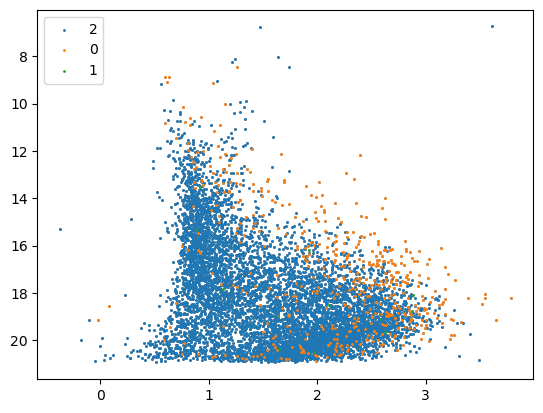

In [36]:
# check the CMD
f, ax = plt.subplots()
ax.scatter(df['bp_rp'],df['phot_g_mean_mag'], s=1, color='gray')
for i, lab in enumerate(df['label'].unique()):
    use_df = df.loc[df['label'] == lab]
    ax.scatter(use_df['bp_rp'],use_df['phot_g_mean_mag'], s=1, label=lab, color=rgb_colors[i])

ax.legend()
plt.gca().invert_yaxis()

In [37]:
from firefly.data_reader import ParticleGroup, Reader

In [38]:
print(list(rgb_colors[i]) + [1])

[0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1]


In [39]:
# create the Reader
my_reader = Reader()

# identify the columns we should send to firefly for coloring & filtering
field_names = ['SOURCE_ID','parallax','pmra','pmdec','radial_velocity','phot_g_mean_mag','bp_rp','teff_gspphot','ruwe']

# add all the particle groups (one per HDBSCAN cluster)
for i,lab in enumerate(df['label'].unique()):
    print(lab)
    use_df = df.loc[df['label'] == lab]
    coords = use_df[['x','y','z']].to_numpy()
    fields = np.nan_to_num(use_df[field_names].to_numpy(), nan=-999).T
    group = ParticleGroup(
        'group' + str(lab),
        coords,
        field_arrays=fields, 
        field_names=field_names,
        partsColors=list(rgb_colors[i]) + [1]
    ) 
    my_reader.addParticleGroup(group)

datadir is None, defaulting to /opt/anaconda3/lib/python3.9/site-packages/firefly/static/data/Data
2
Make sure each field_array (9) has a field_filter_flag (0), assuming True.
Make sure each field_array (9) has a field_colormap_flag (0), assuming True.
Make sure each field_array (9) has a field_radius_flag (0), assuming False.
0
Make sure each field_array (9) has a field_filter_flag (0), assuming True.
Make sure each field_array (9) has a field_colormap_flag (0), assuming True.
Make sure each field_array (9) has a field_radius_flag (0), assuming False.
1
Make sure each field_array (9) has a field_filter_flag (0), assuming True.
Make sure each field_array (9) has a field_colormap_flag (0), assuming True.
Make sure each field_array (9) has a field_radius_flag (0), assuming False.


In [40]:
from firefly.server import spawnFireflyServer,quitAllFireflyServers

In [41]:
# define the local port (typically anything in 5000 - 8000 range)
port = 5500

In [42]:
process = spawnFireflyServer(port, method = 'flask')

Waiting up to 10 seconds for background Firefly server to start...done! Your server is available at - http://localhost:5500


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Launching Firefly at: http://localhost:5500
from directory /opt/anaconda3/lib/python3.9/site-packages/firefly


 * Restarting with watchdog (fsevents)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Launching Firefly at: http://localhost:5500
from directory /opt/anaconda3/lib/python3.9/site-packages/firefly


In [43]:
from IPython.display import IFrame
url = f'http://localhost:{port:d}/combined'
IFrame(url, width=1000, height=500)

In [44]:
# Send data to the server.
# Wait until it loads to run this command
my_reader.sendDataViaFlask()

group2 - 7272/7272 particles - 9 tracked fields
group0 - 530/530 particles - 9 tracked fields
group1 - 12/12 particles - 9 tracked fields
Posting data on port 5500...data posted!


In [45]:
import requests

In [51]:
# send a get request to receive the current settings from Firefly
# for larger amounts of data, you will need to increase the waitTime (in seconds) via params (see below; the default is 10s)
r = requests.get(url = f'http://localhost:{port:d}/get_selected_data', params = {'waitTime':60})
if r.status_code == 200:
    # success
    selection = r.json()
    # as a check
    partsKeys = list(selection.keys())
    print(partsKeys)
    print(selection[partsKeys[0]]['Coordinates_flat'][:100]) 
else:
    print('Error: {}'.format(r.status_code), r.content)


Error: 504 b'Timeout.  Please increase the waitTime using the params keyword'


In [52]:
part4 = selection['group2']
part4.keys()

NameError: name 'selection' is not defined

NameError: name 'part4' is not defined

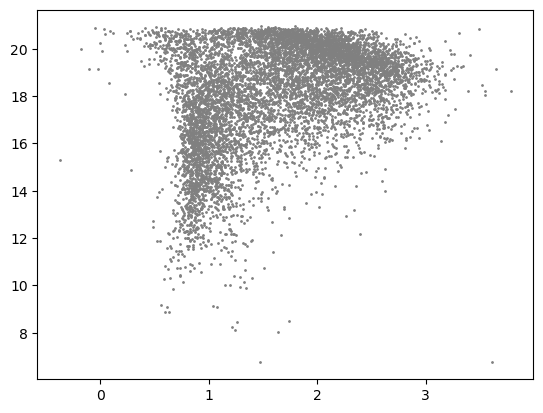

In [48]:
f,ax = plt.subplots()

# all
ax.scatter(df['bp_rp'],df['phot_g_mean_mag'], s=1,color='gray', label='all')

# original
use_df = df.loc[df['label'] == 4]
ax.scatter(use_df['bp_rp'],use_df['phot_g_mean_mag'], s=1, color=rgb_colors[2], label='org')

# selection
ax.scatter(part4['bp_rp'],part4['phot_g_mean_mag'], s=5, color='black', label='selected')

ax.legend()
plt.gca().invert_yaxis()

In [ ]:
return_code = quitAllFireflyServers()